미래에셋 자산운용  
AI 혁신본부 AI 혁신팀 사전 과제 제출용

1. 데이터 불러오기
2. 데이터 살펴보기
3. 전처리 파이프라인 만들기
4. 모델 학습과 선택
5. 제출

기본 설정

In [0]:
import numpy as np 
import os  
import matplotlib
import matplotlib.pyplot as plt
import sklearn 
import pandas as pd
import tensorflow as tf 

from IPython.display import display

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

matplotlib.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.unicode_minus'] = False 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving mirae.zip to mirae.zip


In [3]:
!unzip mirae.zip

Archive:  mirae.zip
  inflating: mirae/test_data.csv     
  inflating: mirae/train_data.csv    
  inflating: mirae/train_target.csv  
  inflating: mirae/train_target2.csv  


In [4]:
os.listdir()

['.config', 'mirae.zip', 'mirae', 'sample_data']

# 1. 데이터 불러오기

In [0]:
DATA = pd.read_csv('mirae//train_data.csv', engine='python')
TARGET1 = pd.read_csv('mirae//train_target.csv', engine='python')
TARGET2 =  pd.read_csv('mirae//train_target2.csv', engine='python')
SUBMISSION = pd.read_csv('mirae//test_data.csv', engine='python')

In [6]:
display(DATA.head())
display(TARGET1.head())
display(TARGET2.head())

,td,code,F001,F002,F003,F004,F005,F006,F007,F008,...,F037,F038,F039,F040,F041,F042,F043,F044,F045,F046
0,T001,A005,7.267364,0.004896,0.945559,-0.828748,0.641026,-0.038719,0.015282,-1.015634,...,-1.567398,0.007646,0.002793,1.0,0.004724,-1.041667,13.357401,0.793424,11.347518,0.544470
1,T001,A006,-7.477904,-0.000128,1.089255,0.042335,7.640449,0.038965,0.016616,-0.631765,...,-1.033058,-0.001463,-0.002713,2.0,-0.004431,2.040816,-14.464286,0.546866,-4.960317,3.914780
2,T001,A007,7.622525,0.001413,1.260723,0.001667,13.735577,0.025740,0.012530,6.140861,...,7.648485,0.003168,-0.000951,6.0,-0.004544,0.000000,13.052749,0.523903,-1.228115,9.910044
3,T001,A011,51.693204,0.000000,6.967351,0.268144,-11.543311,0.143675,0.033834,0.401105,...,1.358087,0.037001,-0.004078,2.0,0.012924,-7.142857,156.242771,1.050259,137.679277,-2.979930
4,T001,A012,-7.707446,-0.000763,1.201887,0.285988,21.070234,-0.006894,0.017134,0.497051,...,0.835655,-0.059726,-0.000538,5.0,-0.000045,0.000000,-17.351598,0.865144,-17.539863,12.087614


,td,code,target
0,T001,A005,-0.041401
1,T001,A006,-0.010438
2,T001,A007,-0.042630
3,T001,A011,0.109743
4,T001,A012,0.058011


,td,code,target
0,T001,A005,0
1,T001,A006,2
2,T001,A007,0
3,T001,A011,4
4,T001,A012,4


체크 사항  
1. 훈련 데이터의 특성의 경우 td, code와 F0__라는 식의 특성들이 있다.
2. 타겟 파일의 경우 td, code와 타겟값이 있다.
3. td의 경우 날짜정보, code의 경우 종목정보를 나타낸다.

# 2. 데이터 살펴보기

Classification을 위해 TARGET2 데이터를 카피하자.

In [7]:
data = DATA.copy()
data['target'] = TARGET2["target"].copy()
submission = SUBMISSION.copy()

data.drop(['td','code'], axis=1, inplace=True)
submission.drop(['td','code'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83564 entries, 0 to 83563
Data columns (total 47 columns):
F001      80147 non-null float64
F002      72494 non-null float64
F003      82138 non-null float64
F004      83448 non-null float64
F005      83448 non-null float64
F006      69456 non-null float64
F007      82518 non-null float64
F008      82504 non-null float64
F009      71432 non-null float64
F010      70884 non-null float64
F011      82867 non-null float64
F012      80464 non-null float64
F013      83445 non-null float64
F014      70398 non-null float64
F015      83383 non-null float64
F016      83383 non-null float64
F017      71637 non-null float64
F018      82717 non-null float64
F019      70839 non-null float64
F020      82908 non-null float64
F021      80017 non-null float64
F022      83410 non-null float64
F023      70145 non-null float64
F024      80812 non-null float64
F025      83392 non-null float64
F026      71295 non-null float64
F027      81626 non-null float64


체크 사항
1. 주어진 데이터는 83564 객체가 있다.
2. 특성의 경우 48개가 있다.
3. object으로 저장된 특성은 td와 code가 있다.
4. td와 code를 제외하고 거의 모든 특성들에 결측치가 있다.

## 1. 결측치 살펴보기

In [8]:
data.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62109 entries, 0 to 83563
Data columns (total 47 columns):
F001      62109 non-null float64
F002      62109 non-null float64
F003      62109 non-null float64
F004      62109 non-null float64
F005      62109 non-null float64
F006      62109 non-null float64
F007      62109 non-null float64
F008      62109 non-null float64
F009      62109 non-null float64
F010      62109 non-null float64
F011      62109 non-null float64
F012      62109 non-null float64
F013      62109 non-null float64
F014      62109 non-null float64
F015      62109 non-null float64
F016      62109 non-null float64
F017      62109 non-null float64
F018      62109 non-null float64
F019      62109 non-null float64
F020      62109 non-null float64
F021      62109 non-null float64
F022      62109 non-null float64
F023      62109 non-null float64
F024      62109 non-null float64
F025      62109 non-null float64
F026      62109 non-null float64
F027      62109 non-null float64


결측치가 있는 객체를 모두 제거할 경우, 약 20000개의 데이터가 손실된다. 약 20000개의 데이터의 손실은 전체 훈련 데이터의 1/4 정도의 손실이다.

In [9]:
data.isnull().sum()

F001       3417
F002      11070
F003       1426
F004        116
F005        116
F006      14108
F007       1046
F008       1060
F009      12132
F010      12680
F011        697
F012       3100
F013        119
F014      13166
F015        181
F016        181
F017      11927
F018        847
F019      12725
F020        656
F021       3547
F022        154
F023      13419
F024       2752
F025        172
F026      12269
F027       1938
F028      11059
F029        143
F030        116
F031        116
F032        156
F033      12497
F034       3295
F035        996
F036      12479
F037        116
F038       3226
F039      12506
F040        181
F041      13515
F042      15680
F043        116
F044          5
F045        116
F046        462
target        0
dtype: int64

제일 결측치가 많은 특성은 F042이다. 약 만오천개의 결측치가 있는데 전체 데이터의 1/5 정도이고 이 정도면 특성을 삭제하거나, 객체를 제거하는 것보다 결측치를 채우는 것이 더 낫다고 판단된다.

## 2. 데이터 시각화
### 1. 수치형 변수의 도수분포표

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


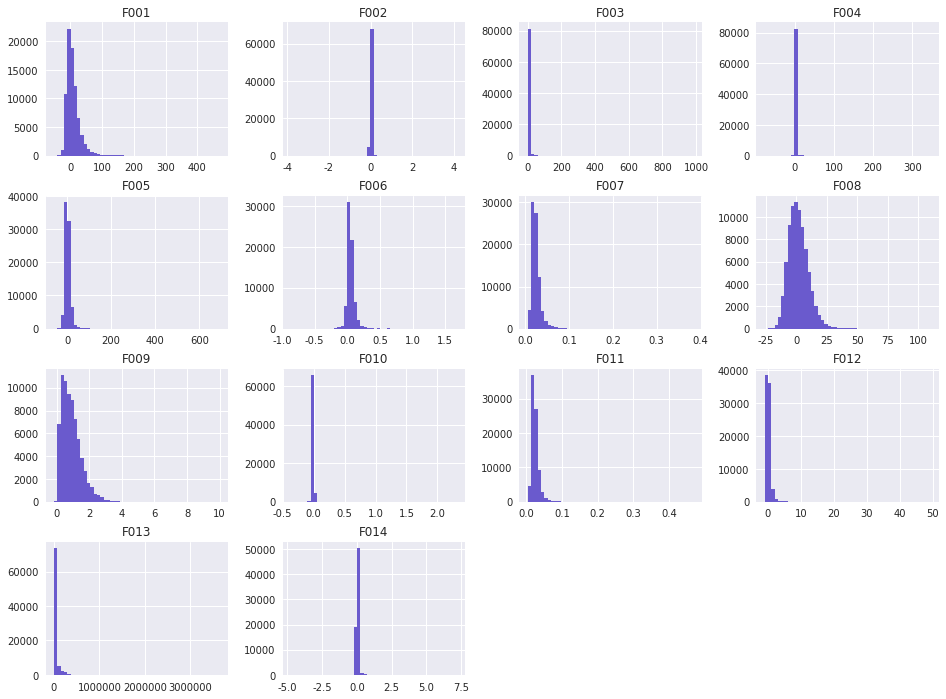

,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014
count,80147.000000,72494.000000,82138.000000,83448.000000,83448.000000,69456.000000,82518.000000,82504.000000,71432.000000,70884.000000,82867.000000,80464.000000,8.344500e+04,70398.000000
mean,7.894370,0.000915,3.212757,0.202291,2.075079,0.052969,0.024497,1.753955,0.909854,-0.000027,0.024370,0.228121,4.032338e+04,0.046942
std,22.101300,0.039230,17.267118,2.020238,14.543002,0.069505,0.011561,8.342232,0.601707,0.016406,0.012083,0.769835,1.418674e+05,0.132913
min,-52.092279,-3.832419,0.169382,-76.840000,-59.385189,-0.866186,0.005690,-26.092628,-0.165837,-0.367137,0.003439,-0.958573,2.664000e+03,-4.746435
25%,-6.103297,-0.001195,0.919447,-0.020000,-5.553225,0.020651,0.017816,-4.073285,0.440529,-0.001739,0.017460,-0.129312,6.503220e+03,0.014973
50%,3.184114,0.000000,1.551248,0.000000,0.440529,0.042782,0.022341,0.917061,0.800000,0.000000,0.022058,0.062735,1.240721e+04,0.037237
75%,16.197738,0.000400,3.090994,0.059686,7.606289,0.073355,0.028253,6.597034,1.234568,0.001397,0.028192,0.359261,3.039216e+04,0.067633
max,470.723992,4.133958,983.606913,345.800000,691.925065,1.670955,0.383658,109.968661,10.000000,2.307626,0.468572,49.238095,3.640578e+06,7.161950


In [10]:
data.iloc[:, :14].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data.iloc[:, :14].describe())

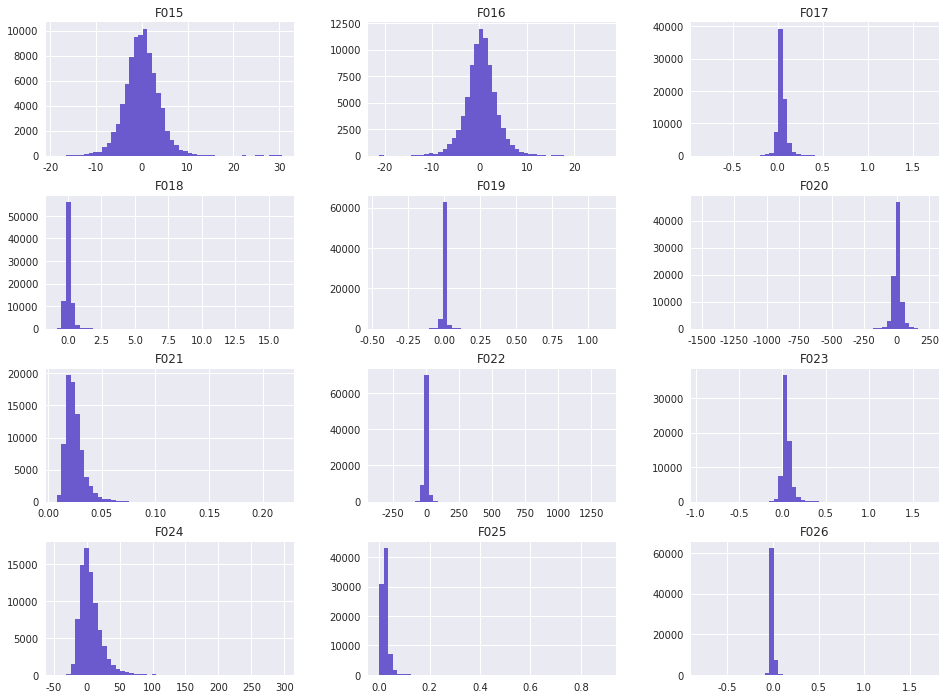

,F015,F016,F017,F018,F019,F020,F021,F022,F023,F024,F025,F026
count,83383.000000,83383.000000,71637.000000,82717.000000,70839.000000,82908.000000,80017.000000,83410.000000,70145.000000,80812.000000,83392.000000,71295.000000
mean,-0.030110,0.321484,0.049640,0.056761,-0.001016,2.296417,0.024672,0.259129,0.051908,5.707921,0.023405,0.001681
std,3.777982,3.304472,0.056603,0.299828,0.019365,34.702022,0.009251,17.116941,0.065942,17.248487,0.013741,0.026073
min,-18.528906,-21.148030,-0.843800,-0.807115,-0.451408,-1499.547445,0.008150,-353.201172,-0.929443,-44.998364,0.000000,-0.781277
25%,-2.272332,-1.505424,0.023111,-0.084112,-0.003457,-10.841668,0.018753,-5.360640,0.021709,-5.530151,0.015391,-0.001900
50%,-0.061928,0.362394,0.042602,0.017639,-0.000189,2.167657,0.023005,0.017797,0.042704,2.503850,0.020692,0.000985
75%,2.164566,2.176982,0.068093,0.140187,0.001347,15.990866,0.028243,5.762944,0.071301,13.121715,0.027837,0.004464
max,30.691952,26.500946,1.662323,16.010309,1.116911,234.261384,0.218381,1352.978276,1.669305,297.126526,0.895348,1.693431


In [11]:
data.iloc[:, 14:26].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data.iloc[:, 14:26].describe())

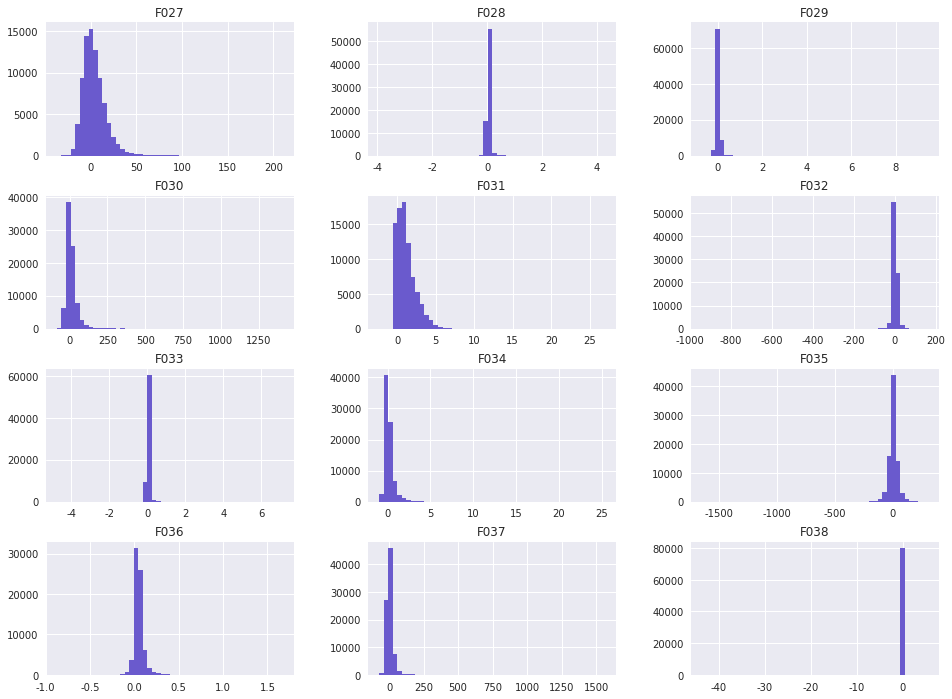

,F027,F028,F029,F030,F031,F032,F033,F034,F035,F036,F037,F038
count,81626.000000,72505.000000,83421.000000,83448.000000,83448.000000,83408.000000,71067.000000,80269.000000,82568.000000,71085.000000,83448.000000,80338.000000
mean,3.629038,0.043050,0.008528,11.835276,1.193595,0.605239,0.045751,0.219851,3.422978,0.050507,6.097276,0.003239
std,12.878910,0.073059,0.096566,45.999533,1.256675,13.266900,0.112927,0.709107,44.191253,0.060596,29.899738,0.328621
min,-37.000024,-3.923003,-0.720634,-84.214294,-2.331606,-942.709728,-4.734186,-0.958573,-1650.772459,-0.871131,-70.219780,-43.672986
25%,-4.945935,0.017796,-0.038655,-10.224090,0.282359,-3.901836,0.016176,-0.130435,-13.953701,0.022688,-8.556635,-0.006791
50%,1.569848,0.037109,0.000000,2.730415,0.838926,0.473877,0.037271,0.061333,3.166523,0.042707,1.724138,0.002463
75%,9.911651,0.061685,0.046034,22.244340,1.754386,5.170179,0.065200,0.355680,21.759228,0.069268,14.653135,0.014523
max,209.954156,4.280389,9.423453,1407.389163,26.966292,157.884076,7.102284,25.357143,297.243414,1.668721,1563.043478,5.317080


In [12]:
data.iloc[:, 26:38].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data.iloc[:, 26:38].describe())

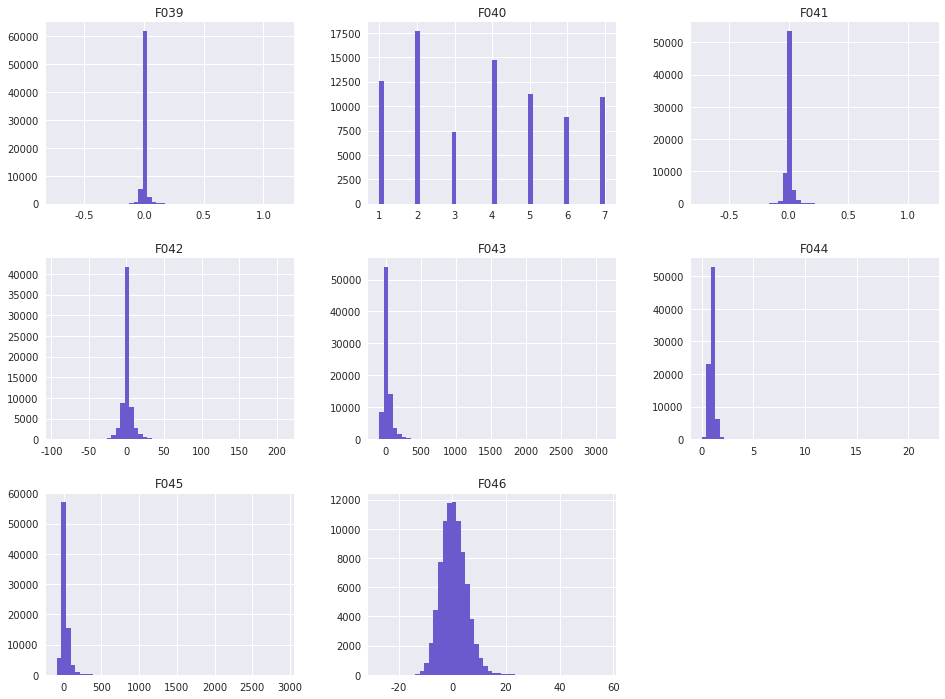

,F039,F040,F041,F042,F043,F044,F045,F046
count,71058.000000,83383.000000,70049.000000,67884.000000,83448.000000,83559.000000,83448.000000,83102.000000
mean,0.001637,3.776357,0.003051,0.678024,23.730528,1.000124,17.703937,0.495890
std,0.025129,1.994943,0.034708,8.502843,76.855077,0.269099,61.836535,4.649171
min,-0.727923,1.000000,-0.727923,-92.500000,-92.017722,0.013118,-89.843290,-27.129617
25%,-0.002727,2.000000,-0.005400,-1.198204,-12.293946,0.864735,-11.295780,-2.745036
50%,0.000000,4.000000,0.000000,0.000000,5.000000,0.985998,4.213260,0.234027
75%,0.002716,5.000000,0.007320,2.083333,36.567964,1.102857,29.559748,3.478132
max,1.160028,7.000000,1.160612,207.692308,3125.524476,21.820324,2900.000000,56.845020


In [13]:
data.iloc[:, 38:-1].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data.iloc[:, 38:-1].describe()) ## target 제외

체크 사항
1. log화가 필요한 특성들이 보인다.  
    ['F001', 'F003', 'F004', 'F005',  
     'F007', 'F009', 'F010', 'F011',  
     'F012', 'F013', 'F018', 'F024',  
     'F021', 'F025', 'F029', 'F030',  
     'F031', 'F034', 'F020'(x=2.5 대칭 후 로그화), 'F032'(x=2.5 대칭 후 로그화),  
     'F035'(y축 대칭 후 로그화)]  
2. F040의 경우 명목형 변수로 사용할 수도 있을 것 같다.

### 2. 타겟값

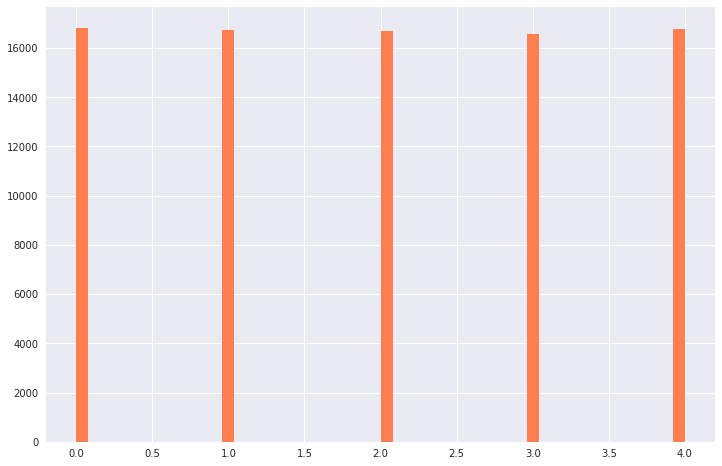

count    83564.000000
mean         1.996673
std          1.416501
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: target, dtype: float64

In [14]:
data["target"].hist(bins=50, figsize=(12,8), color='coral')
plt.show()
display(data["target"].describe())

체크 사항
1. target1과는 다르게 균등하게 분포되어있다.

### 3. 상관관계 분석

In [0]:
corr_matrix = data.corr()

특성과 타겟의 상관관계가 매우 낮은 걸 볼 수 있다. 그림을 통해 살펴보자.

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


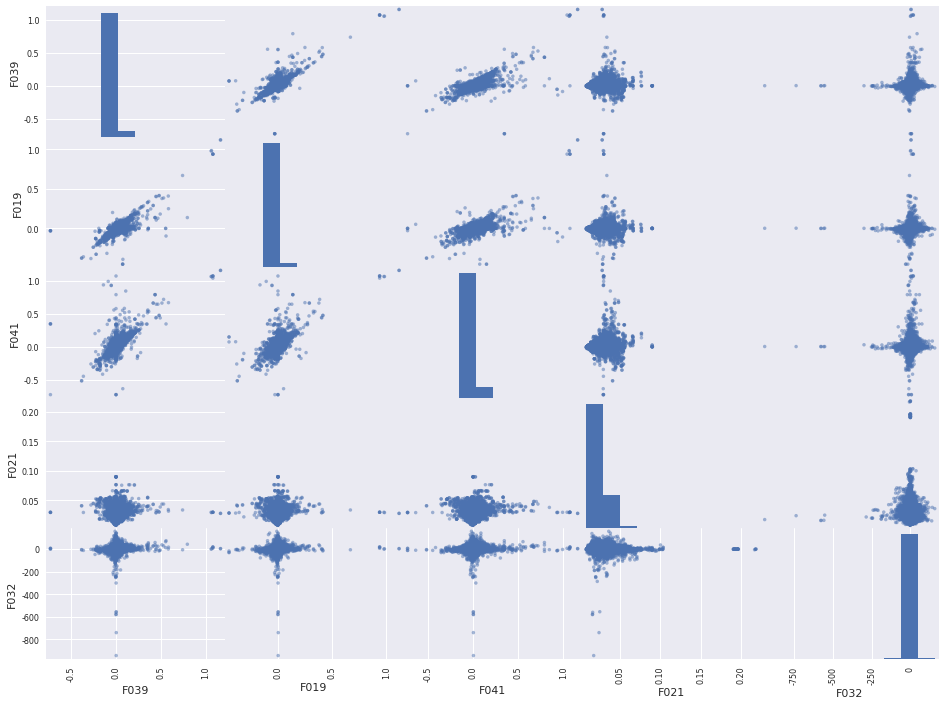

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["F039","F019", "F041", "F021", "F032"]
scatter_matrix(data[attributes], figsize=(16, 12))
plt.show()

특성들끼리 상관관계가 있는 모습이 보인다. 전처리 단계에서 PCA를 통해 이러한 상관관계를 줄이도록 해보겠다.

In [17]:
dir()

['DATA',
 'In',
 'Out',
 'SUBMISSION',
 'TARGET1',
 'TARGET2',
 '_',
 '_4',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_sh',
 'attributes',
 'corr_matrix',
 'data',
 'display',
 'exit',
 'files',
 'get_ipython',
 'matplotlib',
 'np',
 'os',
 'pd',
 'plt',
 'quit',
 'reset_graph',
 'scatter_matrix',
 'sklearn',
 'submission',
 'tf',
 'uploaded']

In [0]:
del DATA, TARGET1, TARGET2
del attributes, corr_matrix
del scatter_matrix

## 3. 전처리와 파이프라인 만들기
### 1. 수치형 변수 전처리

In [19]:
num_attribute = list(data.columns[:-8]) + list(data.columns[-7:-1])
cat_attribute = ["F040"]
print(len(num_attribute + cat_attribute))

data_num = data[num_attribute].copy()

46


#### 1. 결측치 처리

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
tmp = imputer.fit_transform(data_num)

data_num_tr = pd.DataFrame(tmp, columns=num_attribute)
data_num_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83564 entries, 0 to 83563
Data columns (total 45 columns):
F001    83564 non-null float64
F002    83564 non-null float64
F003    83564 non-null float64
F004    83564 non-null float64
F005    83564 non-null float64
F006    83564 non-null float64
F007    83564 non-null float64
F008    83564 non-null float64
F009    83564 non-null float64
F010    83564 non-null float64
F011    83564 non-null float64
F012    83564 non-null float64
F013    83564 non-null float64
F014    83564 non-null float64
F015    83564 non-null float64
F016    83564 non-null float64
F017    83564 non-null float64
F018    83564 non-null float64
F019    83564 non-null float64
F020    83564 non-null float64
F021    83564 non-null float64
F022    83564 non-null float64
F023    83564 non-null float64
F024    83564 non-null float64
F025    83564 non-null float64
F026    83564 non-null float64
F027    83564 non-null float64
F028    83564 non-null float64
F029    83564 non-null 

#### 2. min-max scaling

In [21]:
data_min_max = (data_num_tr - data_num_tr.min())/(data_num_tr.max() - data_num_tr.min()) * 5

data_min_max.describe()

,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,...,F036,F037,F038,F039,F041,F042,F043,F044,F045,F046
count,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,...,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000
mean,0.573688,2.405946,0.015473,0.911441,0.409021,1.811399,0.248783,1.023310,0.529072,0.686248,...,1.814354,0.233634,4.457661,1.932147,1.935294,1.551972,0.179871,0.226303,0.179854,1.644872
std,0.207001,0.022934,0.087037,0.023884,0.096717,0.124878,0.151976,0.304611,0.273620,0.028246,...,0.110023,0.091470,0.032886,0.061369,0.084132,0.127646,0.119348,0.061698,0.103339,0.276054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.443583,2.404859,0.003857,0.908812,0.358358,1.756407,0.161163,0.811825,0.328724,0.684003,...,1.765700,0.188819,4.456685,1.922791,1.916978,1.540679,0.123940,0.195261,0.131404,1.452955
50%,0.537192,2.405371,0.007191,0.909048,0.398264,1.811399,0.221914,0.997505,0.529072,0.686248,...,1.814354,0.220321,4.457645,1.928137,1.931933,1.540679,0.150863,0.223064,0.157389,1.631165
75%,0.645788,2.405946,0.015473,0.909765,0.445727,1.836917,0.297134,1.198250,0.646903,0.688022,...,1.839483,0.259753,4.458733,1.932295,1.940720,1.555550,0.199684,0.249855,0.199611,1.821094
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


#### 3. log화

log화가 필요한 데이터들:  
['F001', 'F003', 'F004', 'F005',  
 'F007', 'F009', 'F010', 'F011',  
 'F012', 'F013', 'F018', 'F024',  
 'F021', 'F025', 'F029', 'F030',  
 'F031', 'F034', 'F020'(x=2.5 대칭 후 로그화), 'F032'(x=2.5 대칭 후 로그화),  
 'F035'(y축 대칭 후 로그화)]  

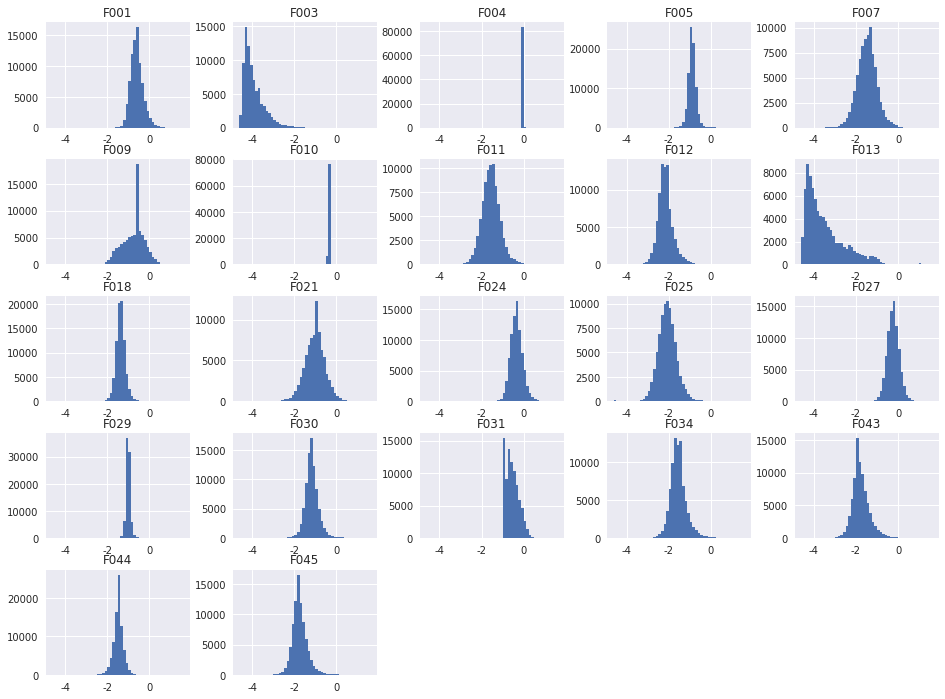

In [22]:
log_data1 = ['F001', 'F003', 'F004', 'F005',
             'F007', 'F009', 'F010', 'F011',
             'F012', 'F013', 'F018', 'F024',
             'F021', 'F025', 'F027', 'F029', 
             'F030', 'F031', 'F034', 'F043',
             'F044', 'F045']
log_data2 = ['F020', 'F032', 'F035'] # y축 대칭 후 로그화

data_log1 = data_min_max[log_data1].copy()
for i in log_data1:
    data_log1.loc[:, i] = data_log1[i] - data_log1[i].min() + 0.01
data_log1 = np.log(data_log1)

data_log1.hist(bins=50, figsize=(16,12))
plt.show()

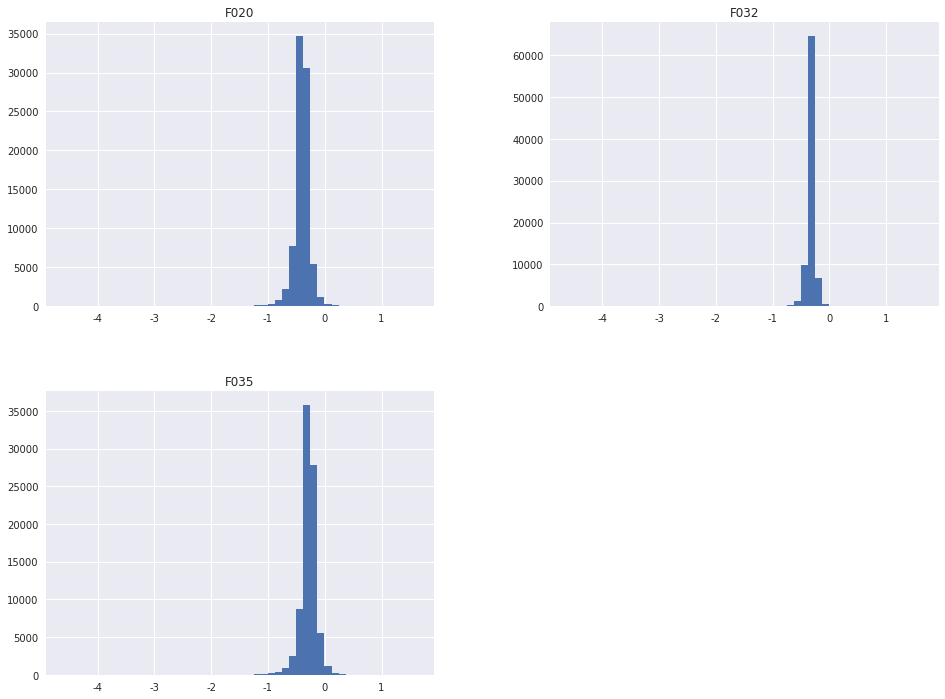

In [23]:
data_log2 = 5 - data_min_max[log_data2]

for i in log_data2:
    data_log2.loc[:, i] = data_log2[i] - data_log2[i].min() + 0.01
data_log2 = np.log(data_log2)

data_log2.hist(bins=50, figsize=(16,12))
plt.show()

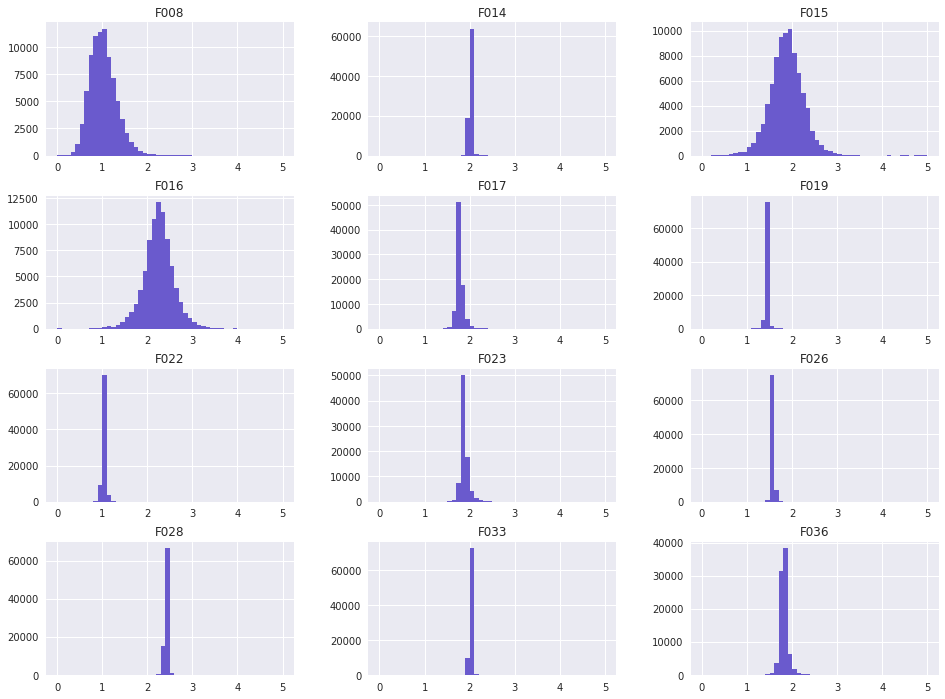

,F002,F006,F008,F014,F015,F016,F017,F019,F022,F023,F026,F028,F033,F036
count,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000
mean,2.405946,1.811399,1.023310,2.012606,1.879162,2.252883,1.782515,1.435907,1.035824,1.888124,1.581920,2.417325,2.019157,1.814354
std,0.022934,0.124878,0.304611,0.051222,0.383363,0.346376,0.104560,0.056843,0.050115,0.116241,0.048659,0.041478,0.043992,0.110023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.404859,1.756407,0.811825,2.001069,1.651488,2.061359,1.735186,1.431026,1.019426,1.837138,1.576359,2.403849,2.008365,1.765700
50%,2.405371,1.811399,0.997505,2.012606,1.876769,2.256397,1.782515,1.436001,1.035152,1.888124,1.581920,2.417325,2.019157,1.814354
75%,2.405946,1.836917,1.198250,2.018349,2.101738,2.446947,1.808787,1.441451,1.051899,1.912379,1.585675,2.426002,2.024795,1.839483
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [24]:
log_data = log_data1 + log_data2
data_with_log = data_min_max.drop(log_data, axis=1).join([data_log1, data_log2]).copy()

data_with_log.iloc[:, 2:14].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data_with_log.iloc[:, :14].describe())

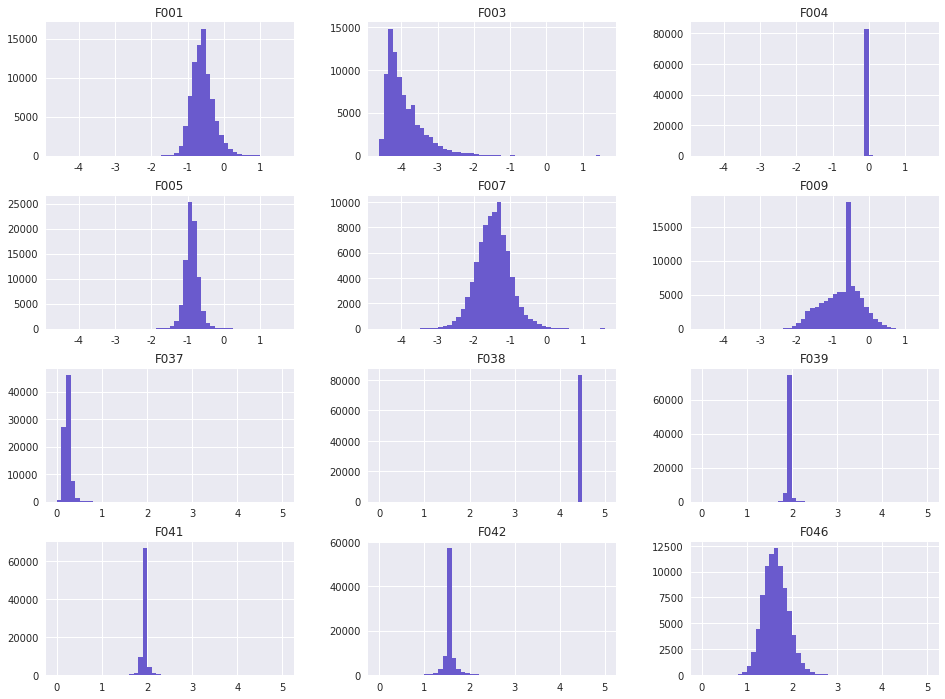

,F037,F038,F039,F041,F042,F046,F001,F003,F004,F005,F007,F009
count,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000
mean,0.233634,4.457661,1.932147,1.935294,1.551972,1.644872,-0.587333,-3.912455,-0.082060,-0.890335,-1.467937,-0.743837
std,0.091470,0.032886,0.061369,0.084132,0.127646,0.276054,0.301959,0.513645,0.024472,0.198035,0.472991,0.514882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170
25%,0.188819,4.456685,1.922791,1.916978,1.540679,1.452955,-0.790576,-4.278992,-0.084674,-0.998700,-1.765140,-1.082571
50%,0.220321,4.457645,1.928137,1.931933,1.540679,1.631165,-0.602955,-4.063360,-0.084417,-0.895842,-1.461389,-0.617907
75%,0.259753,4.458733,1.932295,1.940720,1.555550,1.821094,-0.421917,-3.670130,-0.083637,-0.785862,-1.180470,-0.420218
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436


In [25]:
data_with_log.iloc[:, 14:26].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data_with_log.iloc[:, 14:26].describe())

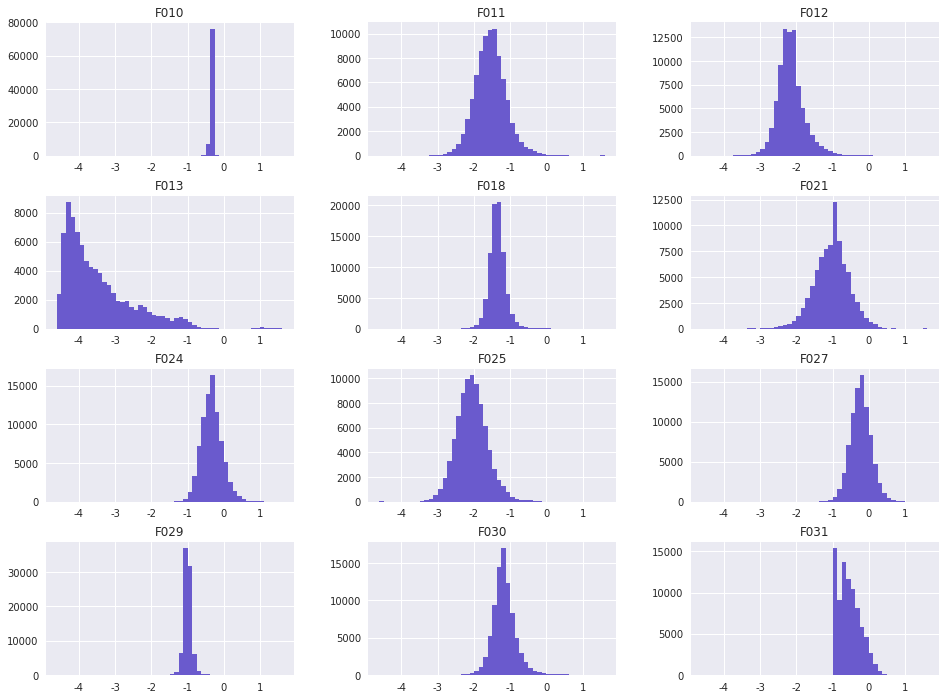

,F010,F011,F012,F013,F018,F024,F021,F025,F027,F029,F030,F031
count,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000
mean,-0.362598,-1.547093,-2.141317,-3.469648,-1.353440,-0.331716,-1.023378,-2.062349,-0.225858,-1.002216,-1.165625,-0.540208
std,0.033952,0.430626,0.385203,0.929579,0.240877,0.294585,0.480987,0.438822,0.289370,0.111099,0.332665,0.300500
min,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170
25%,-0.365280,-1.825461,-2.370647,-4.180956,-1.490445,-0.525878,-1.322425,-2.343196,-0.411940,-1.060798,-1.354444,-0.784874
50%,-0.362049,-1.555406,-2.177448,-3.753931,-1.363451,-0.338717,-0.987581,-2.074187,-0.225546,-1.006221,-1.198698,-0.595429
75%,-0.359505,-1.289865,-1.968943,-3.030408,-1.233830,-0.159577,-0.734398,-1.799798,-0.046323,-0.947163,-1.003130,-0.346782
max,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436


In [26]:
data_with_log.iloc[:, 26:38].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data_with_log.iloc[:, 26:38].describe())

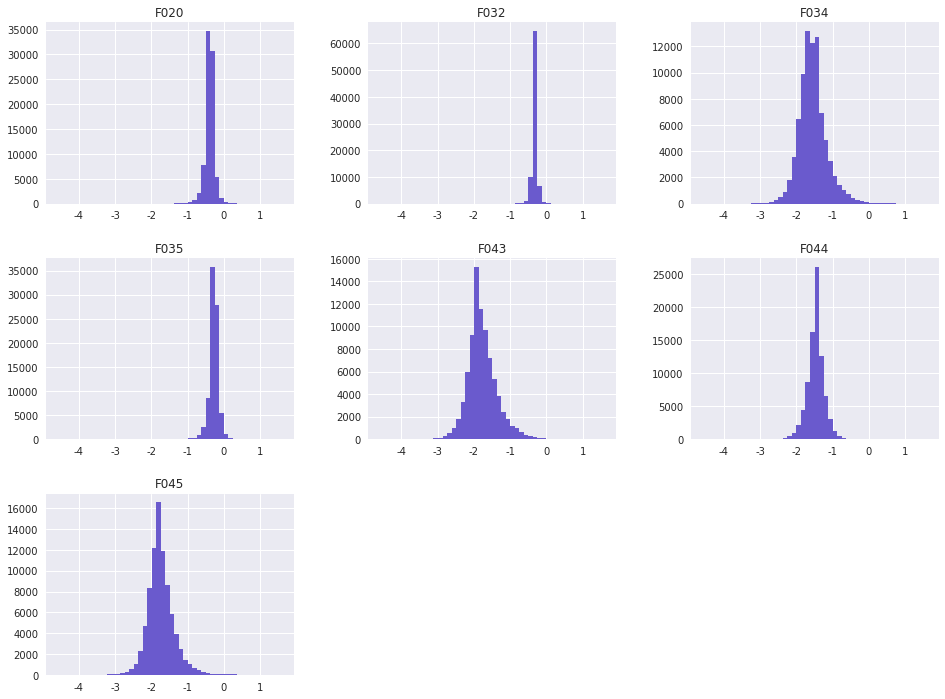

,F034,F043,F044,F045,F020,F032,F035
count,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000
mean,-1.543354,-1.765177,-1.469718,-1.741553,-0.396947,-0.325332,-0.279147
std,0.398216,0.421648,0.233943,0.371913,0.143701,0.079948,0.146042
min,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170
25%,-1.777863,-2.010363,-1.583473,-1.956131,-0.446525,-0.351203,-0.331525
50%,-1.575132,-1.827200,-1.456440,-1.787432,-0.387213,-0.321504,-0.268987
75%,-1.360789,-1.562152,-1.347631,-1.562500,-0.333576,-0.294448,-0.213160
max,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436,1.611436


In [27]:
data_with_log.iloc[:, 38:].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()
display(data_with_log.iloc[:, 38:].describe())

#### 4. min-max scaling again

In [28]:
data_min_max = (data_with_log - data_with_log.min())/(data_with_log.max() - data_with_log.min())

data_min_max.describe()

,F002,F006,F008,F014,F015,F016,F017,F019,F022,F023,...,F029,F030,F031,F034,F043,F044,F045,F020,F032,F035
count,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,...,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000,83564.000000
mean,0.481189,0.362280,0.204662,0.402521,0.375832,0.450577,0.356503,0.287181,0.207165,0.377625,...,0.579569,0.553283,0.653888,0.492522,0.456840,0.504367,0.460640,0.676933,0.688452,0.695882
std,0.004587,0.024976,0.060922,0.010244,0.076673,0.069275,0.020912,0.011369,0.010023,0.023248,...,0.017871,0.053512,0.048338,0.064057,0.067826,0.037632,0.059826,0.023116,0.012860,0.023492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480972,0.351281,0.162365,0.400214,0.330298,0.412272,0.347037,0.286205,0.203885,0.367428,...,0.570146,0.522910,0.614531,0.454799,0.417399,0.486069,0.426123,0.668957,0.684291,0.687456
50%,0.481074,0.362280,0.199501,0.402521,0.375354,0.451279,0.356503,0.287200,0.207030,0.377625,...,0.578925,0.547963,0.645005,0.487410,0.446863,0.506503,0.453260,0.678498,0.689068,0.697516
75%,0.481189,0.367383,0.239650,0.403670,0.420348,0.489389,0.361757,0.288290,0.210380,0.382476,...,0.588425,0.579422,0.685002,0.521889,0.489498,0.524006,0.489442,0.687126,0.693420,0.706496
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 5. PCA

In [29]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_min_max)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95)+1

pca = PCA(n_components=d)

pca.fit_transform(data_min_max), d

(array([[-0.20914768,  0.16701906, -0.05166635, ...,  0.00408656,
          0.04972852, -0.00283317],
        [-0.21769561,  0.11172307,  0.0033572 , ..., -0.02128977,
          0.01302867,  0.05385521],
        [-0.14051617,  0.14841811, -0.1145431 , ...,  0.00968525,
          0.04966343, -0.01794036],
        ...,
        [ 0.17170475, -0.00535618,  0.02028352, ..., -0.04205515,
          0.03392658, -0.0246537 ],
        [ 0.03155285, -0.03805991,  0.07415447, ..., -0.03617884,
          0.01153375,  0.03055822],
        [ 0.1285898 , -0.12559262,  0.05237085, ..., -0.03382998,
          0.01681466,  0.00986831]]), 15)

In [30]:
col = []
for i in range(d):
    col.append('pca%s' %i)
    
XdD = pd.DataFrame(pca.transform(data_min_max), 
                    columns = col)
XdD.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14
0,-0.209148,0.167019,-0.051666,-0.073438,-0.116180,0.026517,0.025260,0.045496,-0.032483,-0.010650,-0.044788,0.025290,0.004087,0.049729,-0.002833
1,-0.217696,0.111723,0.003357,-0.038942,-0.015304,0.090804,0.042171,0.089238,-0.000277,-0.052233,-0.009171,0.030126,-0.021290,0.013029,0.053855
2,-0.140516,0.148418,-0.114543,0.047680,0.230496,0.096092,0.124959,-0.014331,-0.040112,0.002252,0.008245,0.016559,0.009684,0.049665,-0.017944
3,0.374604,0.050950,0.016118,-0.094585,-0.010689,-0.141623,0.043874,-0.058143,0.000902,-0.002461,0.016248,-0.007260,-0.050140,-0.018263,-0.007431
4,-0.186933,0.030237,0.023918,0.006976,0.045965,0.192544,0.111900,-0.009423,-0.087652,-0.022103,0.023764,0.017974,0.010370,-0.022451,-0.039126


분산을 95% 설명가능한 변수의 개수는 15개다. 15가지 특성을 이용하겠다. 

#### 6. 시각화

In [31]:
data_min_max.drop(num_attribute, axis=1, inplace=True)
data_num_tr = data_min_max.join(XdD)
data_num_tr.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14
0,-0.209148,0.167019,-0.051666,-0.073438,-0.116180,0.026517,0.025260,0.045496,-0.032483,-0.010650,-0.044788,0.025290,0.004087,0.049729,-0.002833
1,-0.217696,0.111723,0.003357,-0.038942,-0.015304,0.090804,0.042171,0.089238,-0.000277,-0.052233,-0.009171,0.030126,-0.021290,0.013029,0.053855
2,-0.140516,0.148418,-0.114543,0.047680,0.230496,0.096092,0.124959,-0.014331,-0.040112,0.002252,0.008245,0.016559,0.009684,0.049665,-0.017944
3,0.374604,0.050950,0.016118,-0.094585,-0.010689,-0.141623,0.043874,-0.058143,0.000902,-0.002461,0.016248,-0.007260,-0.050140,-0.018263,-0.007431
4,-0.186933,0.030237,0.023918,0.006976,0.045965,0.192544,0.111900,-0.009423,-0.087652,-0.022103,0.023764,0.017974,0.010370,-0.022451,-0.039126


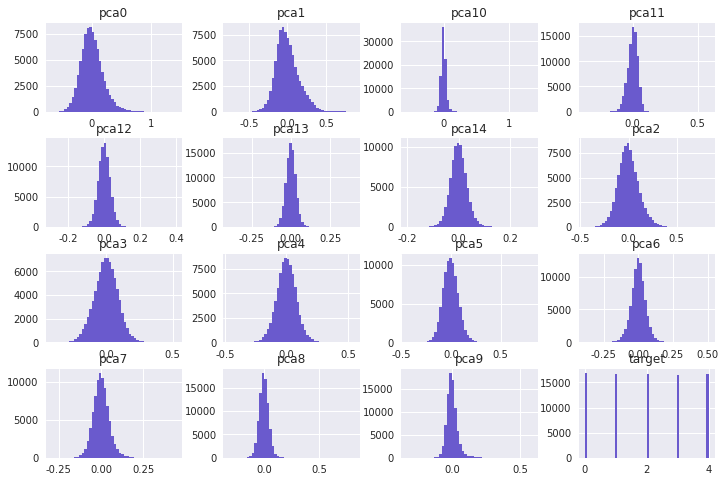

In [32]:
data_num_tr["target"] = data["target"].copy()
data_num_tr.hist(bins=50, figsize=(12,8), color='slateblue')
plt.show()

### 2. 명목형 변수 전처리

In [33]:
data_cat = data[cat_attribute].copy()
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83564 entries, 0 to 83563
Data columns (total 1 columns):
F040    83383 non-null float64
dtypes: float64(1)
memory usage: 652.9 KB


#### 1.  결측치 처리

최빈값으로 처리

In [34]:
data_cat['F040'].value_counts()

2.0    17690
4.0    14687
1.0    12551
5.0    11282
7.0    10891
6.0     8904
3.0     7378
Name: F040, dtype: int64

In [0]:
data_cat['F040'] = data_cat['F040'].fillna(2)

#### 2. OneHot

In [0]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(categories='auto')

In [37]:
one_hot.fit_transform(data_cat).toarray().shape

(83564, 7)

### 3. 파이프라인 만들기
#### 1. train 데이터와 test 데이터 나누기

In [38]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data, test_size=0.2, random_state=42)

train_target = train["target"]
test_target = test["target"]

train.drop('target', axis=1, inplace=True)
test.drop('target', axis=1, inplace=True)

display(train.head())
display(train_target.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,...,F037,F038,F039,F040,F041,F042,F043,F044,F045,F046
55174,-5.537505,0.000000,6.524976,0.000000,-6.276151,0.003580,0.017899,-0.652707,0.171527,-0.007630,...,-1.321586,-0.007810,-0.022889,7.0,-0.031012,-4.395604,-21.219226,0.963250,-20.095125,-3.951822
16039,-7.640945,0.000000,1.432149,0.036692,-17.503155,0.021777,0.017173,-12.698492,0.763359,-0.026918,...,-21.431213,0.007037,-0.026153,1.0,-0.026153,-2.376600,-13.223731,0.979213,-25.839951,-7.389858
47843,-11.844201,0.000268,0.506265,0.139320,-8.818342,0.033945,0.036180,-7.575988,2.083333,-0.000961,...,-26.770538,0.002624,-0.002160,4.0,-0.005845,0.000000,-33.462033,1.054947,-37.860577,-3.331291
63771,7.292332,-0.001619,1.233991,0.121930,2.527076,0.031254,0.017167,4.571109,0.877193,0.000913,...,7.984791,0.011698,-0.000157,5.0,0.001068,2.631579,15.918367,0.919234,4.029304,1.314045
66187,8.676451,-0.014263,2.430123,0.049934,4.547284,0.081127,0.030583,5.399983,0.432900,0.002676,...,16.250280,-0.083794,0.020553,1.0,0.020553,6.666667,25.780683,0.926478,-11.777690,1.651524


55174    4
16039    2
47843    3
63771    2
66187    3
Name: target, dtype: int64

#### 2. 수치형 변수 파이프라인

##### 1. 결측치 처리

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

In [0]:
class imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy=strategy
    def fit(self, X, y=None):
        self.imputer_tmp = SimpleImputer(strategy=self.strategy)
        self.imputer_tmp.fit(X)
        return self
    def transform(self, X, y=None):
        self.index = X.index
        X_tmp = pd.DataFrame(self.imputer_tmp.transform(X), columns=num_attribute,
                            index=self.index)
        return X_tmp

##### 2. min-max scaling, range=[0, 5]

In [0]:
class min_max(BaseEstimator, TransformerMixin):
    def __init__(self, feature_range=(0,1)):
        self.feature_range = feature_range
    def fit(self, X, y=None):
        self.max = X.max()
        self.min = X.min()
        return self
    def transform(self, X, y=None):
        tmp = ((X - self.min)/(self.max - self.min)) * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]
        return tmp

##### 3. log화

In [0]:
class num_log(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_log1 = X[log_data1].copy()
        X_log2 = 5 - X[log_data2]
        
        for i in log_data1:
            X_log1.loc[:, i] = X_log1[i] - X_log1[i].min() + 0.01
        X_log1 = np.log(X_log1)
        
        for i in log_data2:
            X_log2.loc[:, i] = X_log2[i] - X_log2[i].min() + 0.01
        X_log2 = np.log(X_log2)
        
        log_data = log_data1 + log_data2
        
        X_with_log = X.drop(log_data, axis=1).join([X_log1, X_log2]).copy()
        return X_with_log

##### 4. PCA

In [0]:
class num_pca(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=15):
        self.n_components = n_components
    def fit(self, X, y=None):
        from sklearn.decomposition import PCA
        pca = PCA(n_components=self.n_components)
        pca.fit(X)
        return self
    
    def transform(self, X, y=None):
        self.index = X.index
        col = []
        for i in range(d):
            col.append('pca%s' %i)
        
        XdD = pd.DataFrame(pca.transform(X), index=self.index,
                                  columns=col)
        return XdD

##### 5. min-max scaling, range=[0, 1]
##### 6. standard scaling
#### 2. 명목형 변수 파이프라인
##### 1. 결측치

In [0]:
class cat_imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['F040'] = X['F040'].fillna(2.)
        return X

##### 2. OneHot encoding
#### 3. 파이프라인 구축

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
num_pipeline = Pipeline([
    ('imputer', imputer()),
    ('minmax_range_0_5', min_max(feature_range=(0.,5.))),
    ('num_log', num_log()),
    ('num_pca', num_pca(n_components=d)),
    ('minmax_range_0_1', min_max(feature_range=(0.,1.))),
    ('StandardScaler', StandardScaler()) ])

In [0]:
cat_pipeline = Pipeline([
    ('cat_imputer', cat_imputer()),
    ('onehot', OneHotEncoder(categories='auto')),
])

In [0]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribute),
        ('cat', cat_pipeline, cat_attribute),
])

In [49]:
train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(66851, 22)

## 4. 훈련과 모델 선택
### 1. 머신러닝

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


#### 1. SGD Classifier

In [51]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(train_prepared, train_target)

sgd_train_pred = cross_val_predict(sgd_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, sgd_train_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19.

array([[2125, 3098, 2027, 2888, 3299],
       [1961, 3166, 2379, 2704, 3207],
       [1886, 3215, 2524, 2619, 3058],
       [1840, 3174, 2431, 2670, 3155],
       [1952, 3112, 2097, 2956, 3308]])

In [52]:
cross_val_score(sgd_clf, train_prepared, train_target, cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19.

array([0.21202603, 0.20360813, 0.20333887])

랜덤으로 분류한 것과 거의 비슷한 결과다.

#### 2. 소프트맥스 회귀

In [53]:
from sklearn.linear_model import LogisticRegression
softmax_clf = LogisticRegression(multi_class="multinomial", solver='lbfgs', C=10)
softmax_clf.fit(train_prepared, train_target)

softmax_train_pred = cross_val_predict(softmax_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, softmax_train_pred)

array([[5047, 1738, 2903,  798, 2951],
       [3546, 2057, 4396,  961, 2457],
       [3156, 1971, 4842, 1018, 2315],
       [3285, 1936, 4542, 1006, 2501],
       [4477, 1688, 3120,  831, 3309]])

In [54]:
cross_val_score(softmax_clf, train_prepared, train_target, cv=3, scoring='accuracy')

array([0.24379628, 0.23964457, 0.24628641])

성능이 조금 나아진 것 같다.

#### 3. 결정트리

In [72]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3, max_features=2,
                                 min_samples_leaf=1, min_samples_split=3)
tree_clf.fit(train_prepared, train_target)

tree_train_pred = cross_val_predict(tree_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, tree_train_pred)

array([[1747, 3679, 1624,  555, 5832],
       [1278, 3833, 2165,  558, 5583],
       [1079, 3762, 2498,  582, 5381],
       [1202, 3771, 2271,  640, 5386],
       [1601, 3752, 1692,  514, 5866]])

In [73]:
cross_val_score(tree_clf, train_prepared, train_target, cv=3, scoring='accuracy')

array([0.20516042, 0.21173092, 0.23484271])

#### 4. 소프트맥스 회귀-배깅

In [79]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    LogisticRegression(multi_class="multinomial", solver='lbfgs', C=10),
    n_estimators=20, max_samples=0.8, 
    bootstrap=True, n_jobs=-1)
bag_clf.fit(train_prepared, train_target)

bag_train_pred = cross_val_predict(bag_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, bag_train_pred)

array([[5025, 1757, 2844,  849, 2962],
       [3516, 2037, 4343, 1018, 2503],
       [3131, 2009, 4719, 1115, 2328],
       [3251, 1957, 4466, 1079, 2517],
       [4455, 1695, 3078,  880, 3317]])

In [80]:
cross_val_score(bag_clf, train_prepared, train_target, cv=3, scoring='accuracy')

array([0.24428988, 0.24238208, 0.24480546])

#### 5. 랜덤 포레스트

In [81]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(train_prepared, train_target)

rnd_train_pred = cross_val_predict(rnd_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, rnd_train_pred)

array([[4965, 1801, 3808,  215, 2648],
       [3447, 1960, 5508,  236, 2266],
       [2990, 1873, 5963,  264, 2212],
       [3167, 1908, 5500,  288, 2407],
       [4468, 1711, 3961,  259, 3026]])

In [82]:
cross_val_score(rnd_clf, train_prepared, train_target, cv=3, scoring='accuracy')

array([0.24195647, 0.24350402, 0.24256159])

#### 6. 소프트맥스 회귀-부스팅

In [85]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    LogisticRegression(multi_class="multinomial", solver='lbfgs', C=10),
    n_estimators=40, algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(train_prepared, train_target)

ada_train_pred = cross_val_predict(ada_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, ada_train_pred)

array([[4789, 1773, 2895,  811, 3169],
       [3405, 2031, 4420,  985, 2576],
       [3022, 2014, 4867, 1006, 2393],
       [3213, 1919, 4560, 1039, 2539],
       [4254, 1711, 3127,  852, 3481]])

In [86]:
cross_val_score(ada_clf, train_prepared, train_target, cv=3, scoring='accuracy')

array([0.24271932, 0.24063187, 0.24395279])

### 2. 딥러닝

딥러닝의 경우, 이미지나 시계열의 데이터가 아니므로 CNN이나 RNN보다는 DNN을 쓰는 것이 낫다고 판단했다.

1. 성능 평가 방법은 위에와 같이 rmse를 관찰한다.
2. 러닝 모델은 뉴런의 개수를 30, 20, 7로 하는 히든 레이어로 구성한다.
3. 러닝 알고리즘은 Adam을 쓰도록 하겠다.

In [87]:
X_train, X_valid = train_prepared[:50000], train_prepared[50000:]
y_train, y_valid = train_target[:50000], train_target[50000:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((50000, 22), (16851, 22), (50000,), (16851,))

In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y.iloc[batch_idx]
        yield X_batch, y_batch

In [104]:
reset_graph()

X = tf.placeholder("float", shape=(None, 22), name='X')
y = tf.placeholder("int32", shape=(None), name='y')

n_hidden1 = 30
n_hidden2 = 20
n_hidden3 = 7
n_outputs = 5

dropout_rate = 0.4
with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", 
                              kernel_initializer=he_init, activation=tf.nn.elu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", 
                              kernel_initializer=he_init, activation=tf.nn.elu)
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate)
    
    hidden3 = tf.layers.dense(hidden2_drop, n_hidden3, name="hidden3", 
                              kernel_initializer=he_init, activation=tf.nn.elu)
    outputs = tf.layers.dense(hidden3, n_outputs, name='outputs', 
                              kernel_initializer=he_init)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=outputs)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(outputs, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 200
batch_size = 10000
batch_acc = []
valid_acc = []


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            _, loss_ = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch})
            
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        batch_acc.append(acc_batch)
        valid_acc.append(acc_valid)
        
        if epoch % 10 == 0:
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)
            print('    loss:', loss_)

    save_path = saver.save(sess, "./mirae_classification.ckpt")

0 배치 데이터 정확도: 0.2091 검증 세트 정확도: 0.21043262
    loss: 1.6582763
10 배치 데이터 정확도: 0.2412 검증 세트 정확도: 0.23369533
    loss: 1.5911895
20 배치 데이터 정확도: 0.2451 검증 세트 정확도: 0.23701857
    loss: 1.5899373
30 배치 데이터 정확도: 0.2433 검증 세트 정확도: 0.23951101
    loss: 1.5866613
40 배치 데이터 정확도: 0.2527 검증 세트 정확도: 0.2419441
    loss: 1.5867548
50 배치 데이터 정확도: 0.2448 검증 세트 정확도: 0.23992641
    loss: 1.5904896
60 배치 데이터 정확도: 0.2528 검증 세트 정확도: 0.23761201
    loss: 1.5860127
70 배치 데이터 정확도: 0.2511 검증 세트 정확도: 0.2390956
    loss: 1.5822023
80 배치 데이터 정확도: 0.2549 검증 세트 정확도: 0.24093525
    loss: 1.5808727
90 배치 데이터 정확도: 0.2533 검증 세트 정확도: 0.24206279
    loss: 1.5847048
100 배치 데이터 정확도: 0.2609 검증 세트 정확도: 0.24176607
    loss: 1.5809963
110 배치 데이터 정확도: 0.2535 검증 세트 정확도: 0.24259688
    loss: 1.5842344
120 배치 데이터 정확도: 0.2587 검증 세트 정확도: 0.24319032
    loss: 1.5816535
130 배치 데이터 정확도: 0.2588 검증 세트 정확도: 0.24431784
    loss: 1.5821904
140 배치 데이터 정확도: 0.2554 검증 세트 정확도: 0.24224082
    loss: 1.5805
150 배치 데이터 정확도: 0.2596 검증 세트 정확도: 0.24336

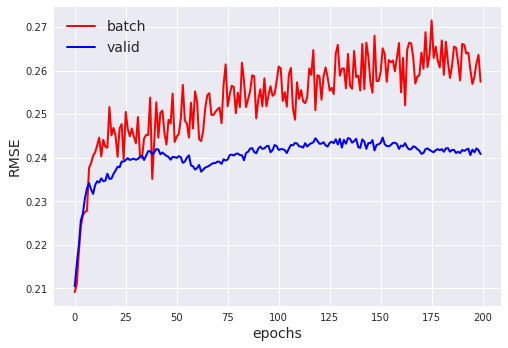

In [105]:
epochs = list(range(n_epochs))

plt.plot(epochs, batch_acc,'r-+', linewidth=2, label='batch')
plt.plot(epochs, valid_acc,'b-', linewidth=2, label='valid')
plt.legend(fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.show()

epoch는 130으로 하겠다

In [107]:
reset_graph()

X = tf.placeholder("float", shape=(None, 22), name='X')
y = tf.placeholder("int32", shape=(None), name='y')

n_hidden1 = 30
n_hidden2 = 20
n_hidden3 = 7
n_outputs = 5

dropout_rate = 0.4
with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", 
                              kernel_initializer=he_init, activation=tf.nn.elu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", 
                              kernel_initializer=he_init, activation=tf.nn.elu)
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate)
    
    hidden3 = tf.layers.dense(hidden2_drop, n_hidden3, name="hidden3", 
                              kernel_initializer=he_init, activation=tf.nn.elu)
    outputs = tf.layers.dense(hidden3, n_outputs, name='outputs', 
                              kernel_initializer=he_init)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=outputs)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(outputs, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 130
batch_size = 10000
batch_acc = []
valid_acc = []


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            _, loss_ = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch})
            
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        batch_acc.append(acc_batch)
        valid_acc.append(acc_valid)
        
        if epoch % 10 == 0:
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)
            print('    loss:', loss_)

    save_path = saver.save(sess, "./mirae_classification.ckpt")

0 배치 데이터 정확도: 0.2091 검증 세트 정확도: 0.21043262
    loss: 1.6582763
10 배치 데이터 정확도: 0.2412 검증 세트 정확도: 0.23369533
    loss: 1.5911895
20 배치 데이터 정확도: 0.2451 검증 세트 정확도: 0.23701857
    loss: 1.5899373
30 배치 데이터 정확도: 0.2433 검증 세트 정확도: 0.23951101
    loss: 1.5866613
40 배치 데이터 정확도: 0.2527 검증 세트 정확도: 0.2419441
    loss: 1.5867548
50 배치 데이터 정확도: 0.2448 검증 세트 정확도: 0.23992641
    loss: 1.5904896
60 배치 데이터 정확도: 0.2528 검증 세트 정확도: 0.23761201
    loss: 1.5860127
70 배치 데이터 정확도: 0.2511 검증 세트 정확도: 0.2390956
    loss: 1.5822023
80 배치 데이터 정확도: 0.2549 검증 세트 정확도: 0.24093525
    loss: 1.5808727
90 배치 데이터 정확도: 0.2533 검증 세트 정확도: 0.24206279
    loss: 1.5847048
100 배치 데이터 정확도: 0.2609 검증 세트 정확도: 0.24176607
    loss: 1.5809963
110 배치 데이터 정확도: 0.2535 검증 세트 정확도: 0.24259688
    loss: 1.5842344
120 배치 데이터 정확도: 0.2587 검증 세트 정확도: 0.24319032
    loss: 1.5816535


In [108]:
os.listdir()

['.config',
 'mirae_classification.ckpt.meta',
 'mirae_classification.ckpt.data-00000-of-00001',
 'mirae_classification.ckpt.index',
 'mirae.zip',
 'checkpoint',
 'mirae',
 'sample_data']

In [0]:
from google.colab import files
files.download('mirae_classification.ckpt.data-00000-of-00001') 
files.download('mirae_classification.ckpt.index') 
files.download('mirae_classification.ckpt.meta') 

### 3. 랜덤 그리드 탐색
#### 1. 소프트맥스 회귀

In [114]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dict = {'C': [0.01, 0.1, 1, 10]}

n_iter_search = 4

random_search = RandomizedSearchCV(softmax_clf, param_distributions=param_dict,
                                   n_iter=n_iter_search, cv=4, random_state=0)
random_search.fit(train_prepared, train_target)

random_search.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [115]:
param_dict = {'C': [5, 10, 50, 100]}

n_iter_search = 4

random_search = RandomizedSearchCV(softmax_clf, param_distributions=param_dict,
                                   n_iter=n_iter_search, cv=4, random_state=0)
random_search.fit(train_prepared, train_target)

random_search.best_estimator_

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [119]:
softmax_clf = LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
softmax_clf.fit(train_prepared, train_target)

softmax_train_pred = cross_val_predict(softmax_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, softmax_train_pred)

array([[5047, 1738, 2903,  798, 2951],
       [3546, 2057, 4396,  961, 2457],
       [3156, 1971, 4842, 1018, 2315],
       [3285, 1936, 4542, 1006, 2501],
       [4477, 1688, 3120,  831, 3309]])

In [120]:
cross_val_score(softmax_clf, train_prepared, train_target, cv=3, scoring='accuracy')

array([0.24379628, 0.23964457, 0.24628641])

#### 2. 소프트맥스 회귀-배깅

In [118]:
param_dict = {'n_estimators': [10, 20, 30, 40, 50],
             "max_samples": [0.2, 0.4, 0.6, 0.8],
             "bootstrap": [True, False]}

bag_clf = BaggingClassifier(
    LogisticRegression(multi_class="multinomial", solver='lbfgs', C=50),
    n_estimators=20, max_samples=0.8, 
    bootstrap=True, n_jobs=-1)

n_iter_search = 20

random_search = RandomizedSearchCV(bag_clf, param_distributions=param_dict,
                                   n_iter=n_iter_search, cv=4, random_state=0)
random_search.fit(train_prepared, train_target)

random_search.best_estimator_

BaggingClassifier(base_estimator=LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=0.2, n_estimators=30, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

BaggingClassifier(base_estimator=LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=0.2, n_estimators=30, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [121]:
bag_clf = random_search.best_estimator_
bag_clf.fit(train_prepared, train_target)

bag_train_pred = cross_val_predict(bag_clf, train_prepared, train_target, cv=3)

confusion_matrix(train_target, bag_train_pred)

array([[5168, 1707, 2924,  824, 2814],
       [3667, 2015, 4407, 1003, 2325],
       [3242, 1964, 4838, 1056, 2202],
       [3382, 1968, 4523, 1068, 2329],
       [4603, 1658, 3108,  899, 3157]])

In [123]:
cross_val_score(bag_clf, train_prepared, train_target, cv=3, scoring='accuracy')

array([0.24267444, 0.2427411 , 0.24462595])

### 4. 테스트

In [124]:
from sklearn.metrics import accuracy_score

test_prepared = full_pipeline.transform(test)

test_prepared.shape, test_target.shape

((16713, 22), (16713,))

#### 1. 소프트맥스 회귀

In [125]:
softmax_clf_test_prediction = softmax_clf.predict(test_prepared)
softmax_clf_accuracy = accuracy_score(test_target, softmax_clf_test_prediction)
softmax_clf_accuracy

0.2435828397056184

#### 2. 소프트맥스 회귀-배깅

In [126]:
bag_clf_test_prediction = bag_clf.predict(test_prepared)
bag_clf_accuracy = accuracy_score(test_target, bag_clf_test_prediction)
bag_clf_accuracy

0.24340333871836295

#### 3. DNN

In [127]:
with tf.Session() as sess:
    saver.restore(sess, './mirae_classification.ckpt')
    print('test accuracy %g' %sess.run(accuracy, feed_dict={X: test_prepared, y: test_target}))

INFO:tensorflow:Restoring parameters from ./mirae_classification.ckpt
test accuracy 0.245378


## 5. 제출

분류에서는 DNN이 가장 높은 성적을 냈다.

In [140]:
submission_prepared = full_pipeline.transform(submission)
with tf.Session() as sess:
    saver.restore(sess, './mirae_classification.ckpt')
    outputs_ = sess.run(outputs, feed_dict={X: submission_prepared})
dnn_clf_submission_prediction = np.argmax(outputs_, axis=1)


submission = SUBMISSION[['td','code']]
submission['target'] = dnn_clf_submission_prediction
submission = submission.set_index(['td', 'code'])
submission.to_csv("final_predictions_classification.csv", header=True, index=False)
submission.head()

INFO:tensorflow:Restoring parameters from ./mirae_classification.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


target
td   code        
T275 A005       2
     A006       4
     A007       2
     A008       0
     A012       0

In [141]:
os.listdir()

['.config',
 'mirae_classification.ckpt.meta',
 'final_predictions_classification.csv',
 'mirae_classification.ckpt.data-00000-of-00001',
 'mirae_classification.ckpt.index',
 'mirae.zip',
 'checkpoint',
 'mirae',
 'sample_data']

In [0]:
from google.colab import files
files.download('final_predictions_classification.csv') 